In [ ]:
import torch

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#CUDA_VISIBLE_DEVICES=3 python3 main.py -v FedAvgFeTs2022 --data-dir Data/Fets2022/Partitioning1/test1  -cd Data/Fets2022/Partitioning1 -e 4 -r 30 -bs 1 -m "fedavg" -t "fets" --test True

/home/taehwan/micromamba/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
def ploting(fedavg, fedprox, fedref, title="MNIST Classification", metric="loss", num=60, thresholds=[0.5,0.7,1]):
    # 예시 데이터
    fedref_colors = ["blue", "orange", "green", "lightcoral", "darkred", "tomato", "red", "khaki", "darkkhaki"]
    
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(fedavg[metric][:num], marker=".",linestyle="--",label="fedavg", color=fedref_colors[0], alpha=1, linewidth=4)
    ax.plot(fedprox[metric][:num], marker=".", linestyle="--" ,label="fedprox(μ:0.5)", color=fedref_colors[1], alpha=1, linewidth=4)
    for i,l in enumerate(fedref):
        ax.plot(l[metric][:num], marker=".", label=l["label"], color=fedref_colors[i+2], linestyle="--", alpha=1, linewidth=4)

    # 메인 축 설정
    ax.set_xlabel("Rounds", fontsize=15)
    if metric=="mHF95":
        ax.set_ylabel(f"HF95", fontsize=15)
    elif metric=="mDice":
        ax.set_ylabel(f"DC", fontsize=15)
    elif metric=="loss":
        ax.set_ylabel(f"FocalDiceLoss", fontsize=15)
    elif metric=="accuracy":
        ax.set_ylabel(f"Accuracy", fontsize=15)
    elif metric=="f1score":
        ax.set_ylabel(f"F1Score", fontsize=15)
    ax.tick_params(axis='x', labelsize=15)
    ax.tick_params(axis='y', labelsize=15)
    # ax.legend(fontsize=15)
    fig.show()

    fig, ax = plt.subplots(figsize=(10, 5))
    ax.set_ylabel("Rounds", fontsize=15)
    if metric=="mHF95":
        ax.set_xlabel(f"HF95-Thresholds", fontsize=15)
    elif metric=="mDice":
        ax.set_xlabel(f"DC-Thresholds", fontsize=15)
    elif metric=="loss":
        ax.set_xlabel(f"FocalDiceLoss-Thresholds", fontsize=15)
    elif metric=="accuracy":
        ax.set_xlabel(f"Accuracy-Thresholds", fontsize=15)
    elif metric=="f1score":
        ax.set_xlabel(f"F1Score-Thresholds", fontsize=15)
    # ax.set_yticks([i for i in np.arange(0, 2*num+1, step=num) if i!=2*num], labels= [i if i!=2*num else "No reach" for i in range(0, 2*num+1, num) if i!=2*num], fontsize=15)
    ax.tick_params(axis='x', labelsize=15)
    ax.tick_params(axis='y', labelsize=15)
    if metric=="loss" or metric=="mHF95":
        for i,t in enumerate(thresholds):
            samples = {"v":[(fedavg[metric]<=t).tolist().index(True) if (fedavg[metric]<=t).any() else len(fedavg[metric])+num,(fedprox[metric]<=t).tolist().index(True) if (fedprox[metric]<=t).any() else len(fedprox[metric])+100,
                                       *list(map(lambda x: (x[metric]<=t).tolist().index(True) if (x[metric]<=t).any() else len(x[metric])+100, fedref))], "colors":fedref_colors}
            S=list(zip(samples["v"], samples["colors"]))
            # S=sorted(S, key=lambda x: x[0], reverse=True)
            for idx, s in enumerate(S):
                plt.bar(i+idx*0.1-0.3, height=s[0], color =s[1], width=0.1, alpha=0.7)
        ax.set_xticks(range(len(thresholds)), [str(round(thresholds[len(thresholds)-i], 4)) for i in range(len(thresholds),0, -1)])
    else:
        for i,t in enumerate(thresholds):
            samples = {"v":[(fedavg[metric]>=t).tolist().index(True) if (fedavg[metric]>=t).any() else len(fedavg[metric])+num,(fedprox[metric]>=t).tolist().index(True) if (fedprox[metric]>=t).any() else len(fedprox[metric])+100,
                                       *list(map(lambda x: (x[metric]>=t).tolist().index(True) if (x[metric]>=t).any() else len(x[metric])+100, fedref))], "colors":fedref_colors}
            S=list(zip(samples["v"], samples["colors"]))
            # S=sorted(S, key=lambda x: x[0], reverse=True)
            for idx, s in enumerate(S):
                plt.bar(i+idx*0.1-0.3, height=s[0], color =s[1], width=0.1, alpha=0.7)
        ax.set_xticks(range(len(thresholds)), [str(round(thresholds[len(thresholds)-i]*100, 4))+"%" for i in range(len(thresholds),0, -1)])
    h,l =ax.get_legend_handles_labels()
    l.append("fedavg")
    l.append("fedprox(μ:0.5)")
    for ref in fedref:
        l.append(ref["label"])
    h.extend([plt.Line2D([0], [0], color=fedref_colors[0], lw=4), plt.Line2D([0], [0], color=fedref_colors[1], lw=4)])
    for i in range(len(fedref)):
        h.append(plt.Line2D([0], [0], color=fedref_colors[i+2], lw=4))
    # ax.legend(h, l, fontsize=15)
    fig.show()

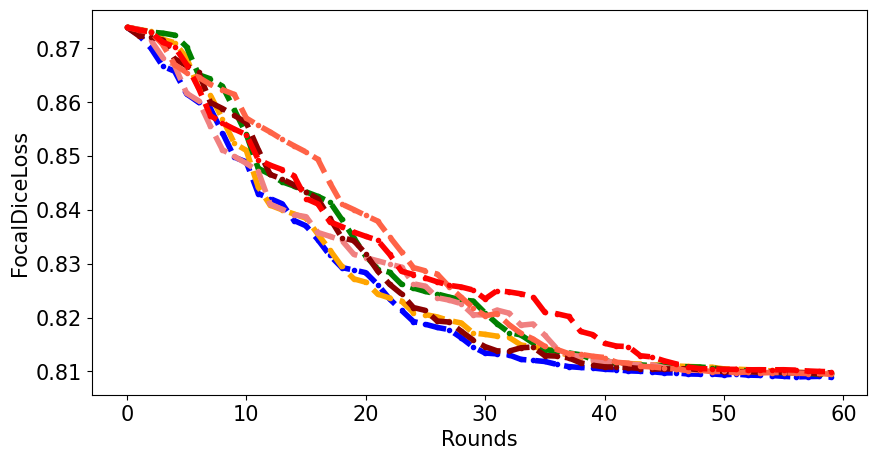

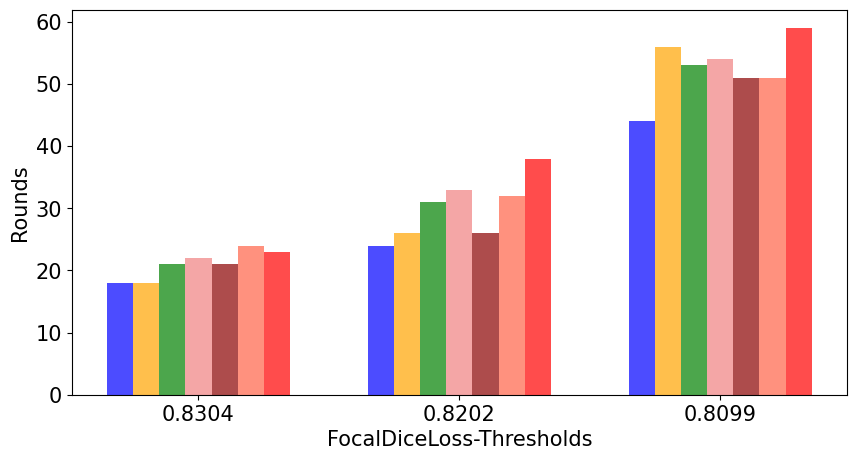

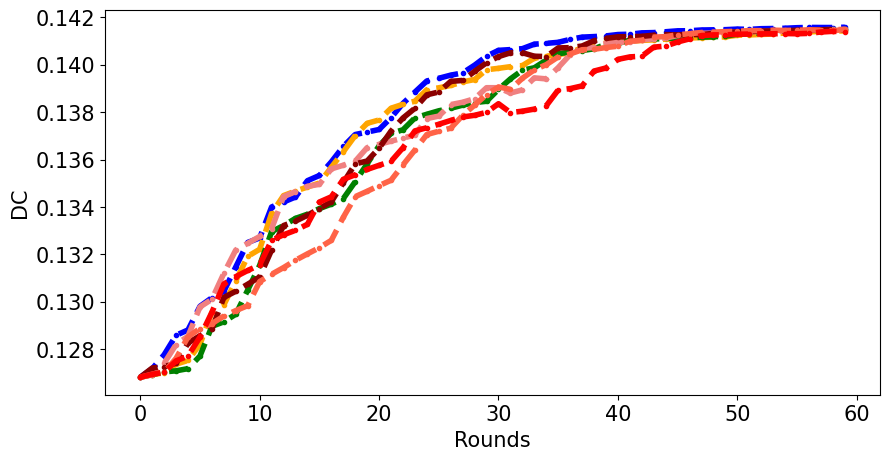

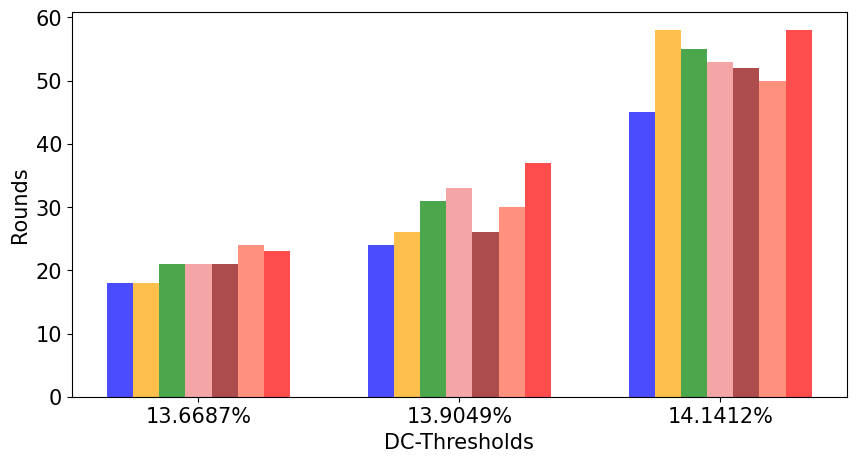

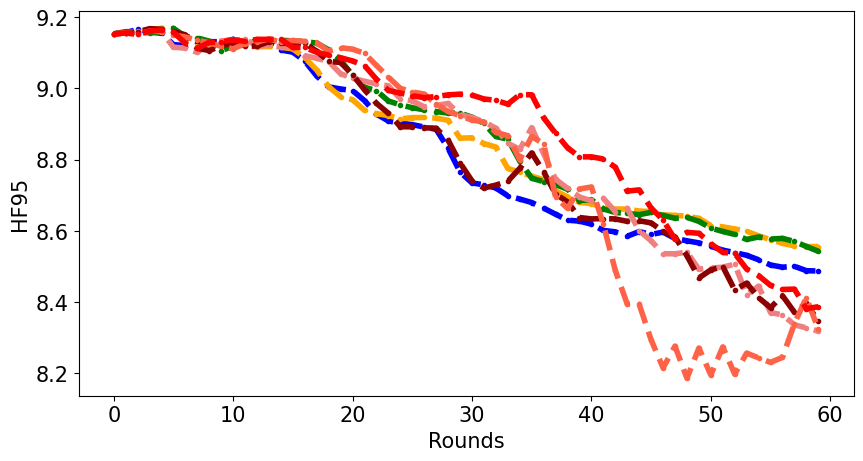

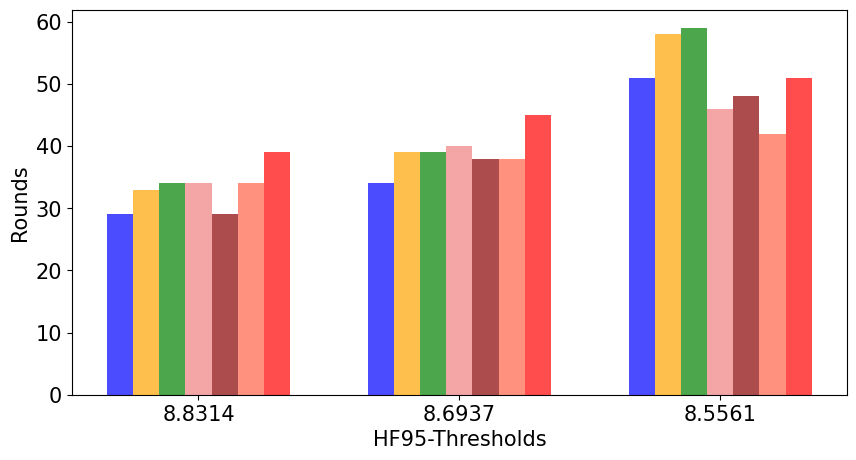

In [9]:
n=60
fedavg = pd.read_csv("Result/fedavg/fedavg_fets.csv")
fedprox = pd.read_csv("Result/fedprox/fedprox_fets.csv")
fedopt = pd.read_csv("Result/fedopt/fedopt_fets.csv")
fedref = [{**fedopt.to_dict("series"), **{"label":"fedopt(η:0.01, β1:0.9, β2:0.99, τ:1e-4)"}},
    {**pd.read_csv("./Result/fedref/fedref_fets_lda11.0_p1.csv").to_dict("series"), **{"label":"fedref(λg:0.1, ρ:1)"}},
    {**pd.read_csv("./Result/fedref/fedref_fets_lda11.0_p3.csv").to_dict("series"), **{"label":"fedref(λg:0.1, ρ:3)"}},
    {**pd.read_csv("./Result/fedref/fedref_fets_lda11.0_p5.csv").to_dict("series"), **{"label":"fedref(λg:0.1, ρ:5)"}},
    {**pd.read_csv("./Result/fedref/fedref_fets_lda11.0_p7.csv").to_dict("series"), **{"label":"fedref(λg:0.1, ρ:7)"}}
    ]
loss_std = max([fedavg["loss"][:n].min()]+[fedprox["loss"][:n].min()]+[min(l["loss"][:n]) for i,l in enumerate(fedref)])
loss_std2 = abs(sum([l["loss"].std() for i,l in enumerate(fedref)])/(len(fedref)))
acc_std = min([fedavg["mDice"][:n].max()]+[fedprox["mDice"][:n].max()]+[l["mDice"][:n].max() for i,l in enumerate(fedref)])
acc_std2 = abs(sum([l["mDice"][:n].std() for i,l in enumerate(fedref)])/(len(fedref)))
f1_score_std = abs(sum([l["mHF95"][:n].std() for i,l in enumerate(fedref)])/(len(fedref)))
f1_score_std2 = max([fedavg["mHF95"][:n].min()]+[fedprox["mHF95"][:n].min()]+[min(l["mHF95"][:n]) for i,l in enumerate(fedref)])
ploting(fedavg, fedprox, fedref, title="FeTs2022 Segmentation ", metric="loss", num=n, thresholds=[loss_std+1*loss_std2, loss_std+0.5*loss_std2, loss_std])
ploting(fedavg, fedprox, fedref, title="FeTs2022 Segmentation", metric="mDice", num=n, thresholds=[acc_std-1*acc_std2, acc_std-0.5*acc_std2, acc_std])
ploting(fedavg, fedprox, fedref, title="FeTs2022 Segmentation", metric="mHF95", num=n, thresholds=[f1_score_std2+1*f1_score_std, f1_score_std2+0.5*f1_score_std, f1_score_std2])

In [35]:
import pandas as pd
import numpy as np
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib import colors as mcolors
import matplotlib.pyplot as plt
def whole_forgetting(fedavg, fedprox, fedopt, fedref, metrics=["loss"], num=60):
    tableau_colors  = ["blue", "orange", "green", "lightcoral", "darkred", "tomato", "red", "khaki", "darkkhaki"]
    fig, ax = plt.subplots(figsize=(10, 5))
    bar_fig, bar_ax = plt.subplots(figsize=(10, 5))
    dictionary = {"updatable":{"fedavg":0,"fedprox":0,"fedopt":0, **{f"fedref{i+1}":0 for i in range(len(fedref))}}, 
                  "forgetting":{"fedavg":0,"fedprox":0,"fedopt":0, **{f"fedref{i+1}":0 for i in range(len(fedref))}},
                  "count":{"fedavg":0,"fedprox":0,"fedopt":0, **{f"fedref{i+1}":0 for i in range(len(fedref))}},
                  "array":{"fedavg":np.zeros_like(fedavg["loss"][:num]),"fedprox":np.zeros_like(fedprox["loss"][:num]),"fedopt":np.zeros_like(fedopt["loss"][:num]),
                           **{f"fedref{i+1}":np.zeros_like(fedref[i]["loss"][:num]) for i in range(len(fedref))}}}
    fedavg = fedavg[:num]
    fedprox = fedprox[:num]
    fedopt = fedopt[:num]
    for metric in metrics:
        if metric=="mHF95" or metric=="loss":
            fedavg_forgetting_count = ((fedavg[metric].values-fedavg[metric].values[-1])<0).sum()
            fedavg_forgetting = (fedavg[metric].values-fedavg[metric].values[-1])[(fedavg[metric].values-fedavg[metric].values[-1])<0].sum()
            fedavg_updatable = (fedavg[metric].values-fedavg[metric].values[-1])[(fedavg[metric].values-fedavg[metric].values[-1])>=0].sum()
            dictionary["array"]["fedavg"] -= (fedavg[metric].values-fedavg[metric].values[-1])
            dictionary["updatable"]["fedavg"]+=fedavg_updatable
            dictionary["forgetting"]["fedavg"]+=fedavg_forgetting
            dictionary["count"]["fedavg"]+=fedavg_forgetting_count
            fedprox_forgetting_count = ((fedprox[metric].values-fedprox[metric].values[-1])<0).sum()
            fedprox_forgetting = (fedprox[metric].values-fedprox[metric].values[-1])[(fedprox[metric].values-fedprox[metric].values[-1])<0].sum()
            fedprox_updatable = (fedprox[metric].values-fedprox[metric].values[-1])[(fedprox[metric].values-fedprox[metric].values[-1])>=0].sum()
            dictionary["array"]["fedprox"] -= (fedprox[metric].values-fedprox[metric].values[-1])
            dictionary["updatable"]["fedprox"]+=fedprox_updatable
            dictionary["forgetting"]["fedprox"]+=fedprox_forgetting
            dictionary["count"]["fedprox"]+=fedprox_forgetting_count
            fedopt_forgetting_count = ((fedopt[metric].values-fedopt[metric].values[-1])<0).sum()
            fedopt_forgetting = (fedopt[metric].values-fedopt[metric].values[-1])[(fedopt[metric].values-fedopt[metric].values[-1])<0].sum()
            fedopt_updatable = (fedopt[metric].values-fedopt[metric].values[-1])[(fedopt[metric].values-fedopt[metric].values[-1])>=0].sum()
            dictionary["array"]["fedopt"] -= (fedopt[metric].values-fedopt[metric].values[-1])
            dictionary["count"]["fedopt"]+=fedopt_forgetting_count
            dictionary["updatable"]["fedopt"]+=fedopt_updatable
            dictionary["forgetting"]["fedopt"]+=fedopt_forgetting
            for i,l in enumerate(fedref):
                forgetting_count = ((l[metric][:num].values-l[metric][:num].values[-1])<0).sum()
                forgetting= (l[metric][:num].values-l[metric][:num].values[-1])[(l[metric][:num].values-l[metric][:num].values[-1])<0].sum()
                updatable = (l[metric][:num].values-l[metric][:num].values[-1])[(l[metric][:num].values-l[metric][:num].values[-1])>=0].sum()
                dictionary["array"][f"fedref{i+1}"] -= (l[metric][:num].values-l[metric][:num].values[-1])
                dictionary["updatable"][f"fedref{i+1}"]+=updatable
                dictionary["forgetting"][f"fedref{i+1}"]+=forgetting
                dictionary["count"][f"fedref{i+1}"]+=forgetting_count
        else:
            fedavg_forgetting_count = ((fedavg[metric].values-fedavg[metric].values[-1])>0).sum()
            fedavg_forgetting = (fedavg[metric].values-fedavg[metric].values[-1])[(fedavg[metric].values-fedavg[metric].values[-1])>0].sum()
            fedavg_updatable = (fedavg[metric].values-fedavg[metric].values[-1])[(fedavg[metric].values-fedavg[metric].values[-1])<=0].sum()
            dictionary["array"]["fedavg"] += (fedavg[metric].values-fedavg[metric].values[-1])
            dictionary["updatable"]["fedavg"]+=fedavg_updatable
            dictionary["forgetting"]["fedavg"]+=fedavg_forgetting
            dictionary["count"]["fedavg"]+=fedavg_forgetting_count
            fedprox_forgetting_count = ((fedprox[metric].values-fedprox[metric].values[-1])>0).sum()
            fedprox_forgetting = (fedprox[metric].values-fedprox[metric].values[-1])[(fedprox[metric].values-fedprox[metric].values[-1])>0].sum()
            fedprox_updatable = (fedprox[metric].values-fedprox[metric].values[-1])[(fedprox[metric].values-fedprox[metric].values[-1])<=0].sum()
            dictionary["array"]["fedprox"] += (fedprox[metric].values-fedprox[metric].values[-1])
            dictionary["updatable"]["fedprox"]+=fedprox_updatable
            dictionary["forgetting"]["fedprox"]+=fedprox_forgetting
            dictionary["count"]["fedprox"]+=fedprox_forgetting_count
            fedopt_forgetting_count = ((fedopt[metric].values-fedopt[metric].values[-1])>0).sum()
            fedopt_forgetting = (fedopt[metric].values-fedopt[metric].values[-1])[(fedopt[metric].values-fedopt[metric].values[-1])>0].sum()
            fedopt_updatable = (fedopt[metric].values-fedopt[metric].values[-1])[(fedopt[metric].values-fedopt[metric].values[-1])<=0].sum()
            dictionary["array"]["fedopt"] += (fedopt[metric].values-fedopt[metric].values[-1])
            dictionary["count"]["fedopt"]+=fedopt_forgetting_count
            dictionary["updatable"]["fedopt"]+=fedopt_updatable
            dictionary["forgetting"]["fedopt"]+=fedopt_forgetting
            for i,l in enumerate(fedref):
                forgetting_count = ((l[metric][:num].values-l[metric][:num].values[-1])>0).sum()
                forgetting= (l[metric][:num].values-l[metric][:num].values[-1])[(l[metric][:num].values-l[metric][:num].values[-1])>0].sum()
                updatable = (l[metric][:num].values-l[metric][:num].values[-1])[(l[metric][:num].values-l[metric][:num].values[-1])<=0].sum()
                dictionary["array"][f"fedref{i+1}"] += (l[metric][:num].values-l[metric][:num].values[-1])
                dictionary["updatable"][f"fedref{i+1}"]+=updatable
                dictionary["forgetting"][f"fedref{i+1}"]+=forgetting
                dictionary["count"][f"fedref{i+1}"]+=forgetting_count

    print(pd.DataFrame(dictionary)[["count","forgetting", "updatable"]])
    ax.set_xlabel("Rounds",fontsize=15)
    if metric=="mHF95":
        ax.set_ylabel("HF95 Forgetting Ratio (ψ)",fontsize=15)
    elif metric=="mDice":
        ax.set_ylabel("DC Forgetting Ratio (ψ)",fontsize=15)
    elif metric=="loss":
        ax.set_ylabel("AsymmLoss Forgetting Ratio (ψ)",fontsize=15)
    elif metric=="accuracy":
        ax.set_ylabel("Accuracy Forgetting Ratio (ψ)",fontsize=15)
    elif metric=="f1score":
        ax.set_ylabel("F1Score Forgetting Ratio (ψ)",fontsize=15)
    ax.tick_params(axis='x', labelsize=15)
    # ax.plot(np.linspace((dictionary["array"]["fedref2"][0]+dictionary["array"]["fedavg"][0])/2, 0, num), color="purple", alpha=0.5,linewidth=2)
    ax.plot(dictionary["array"]["fedavg"], label="FedAvg", color=tableau_colors[0], linestyle="--", alpha=1,linewidth=2)
    ax.plot(dictionary["array"]["fedprox"], label="FedProx", linestyle="--", color=tableau_colors[1], alpha=1, linewidth=2)
    ax.plot(dictionary["array"]["fedopt"], label="FedOpt", linestyle="--", color=tableau_colors[2], alpha=1, linewidth=2)
    for i,l in enumerate(fedref):
        ax.plot(dictionary["array"][f"fedref{i+1}"], label=l["label"], color=tableau_colors[i+3], alpha=1, linewidth=4)
    fig.show()
    bar_ax.tick_params(axis='x', labelsize=15)
    bar_ax.set_xlabel("Methods",fontsize=15)
    if metric=="mHF95":
        bar_ax.set_ylabel("HF95 Forgetting Measure (ζ)",fontsize=15)
    elif metric=="mDice":
        bar_ax.set_ylabel("DC Forgetting Measure (ζ)",fontsize=15)
    elif metric=="loss":
        bar_ax.set_ylabel("AsymmLoss Forgetting Measure (ζ)",fontsize=15)
    elif metric=="accuracy":
        bar_ax.set_ylabel("Accuracy Forgetting Measure (ζ)",fontsize=15)
    elif metric=="f1score":
        bar_ax.set_ylabel("F1Score Forgetting Measure (ζ)",fontsize=15)
    if metric=="mHF95" or metric=="loss":
        bar_ax.bar_label(bar_ax.bar(list(dictionary["count"].keys()) , [-1*(dictionary["updatable"]["fedavg"]+dictionary["forgetting"]["fedavg"]),
                                                                                -1*(dictionary["updatable"]["fedprox"]+dictionary["forgetting"]["fedprox"]),
                                                                                -1*(dictionary["updatable"]["fedopt"]+dictionary["forgetting"]["fedopt"]),
                                                                                *[-1*(dictionary["updatable"][f"fedref{i+1}"]+dictionary["forgetting"][f"fedref{i+1}"]) for i in range(len(fedref))],
                                                                                ]
                                                                                ,color=tableau_colors[:len(list(dictionary["count"].keys()))], alpha=1, width=0.4), fmt='%.4f', fontsize=12)
    else:
        bar_ax.bar_label(bar_ax.bar(list(dictionary["count"].keys()) , [dictionary["updatable"]["fedavg"]+dictionary["forgetting"]["fedavg"],
                                                                                dictionary["updatable"]["fedprox"]+dictionary["forgetting"]["fedprox"],
                                                                                dictionary["updatable"]["fedopt"]+dictionary["forgetting"]["fedopt"],
                                                                                *[dictionary["updatable"][f"fedref{i+1}"]+dictionary["forgetting"][f"fedref{i+1}"] for i in range(len(fedref))],
                                                                                ]
                                                                                ,color=tableau_colors[:len(list(dictionary["count"].keys()))], alpha=1, width=0.4), fmt='%.4f', fontsize=12)
    bar_fig.show()

         count  forgetting  updatable
fedavg       0    0.000000  -0.219923
fedprox      0    0.000000  -0.232109
fedopt       0    0.000000  -0.266086
fedref1      0    0.000000  -0.245612
fedref2      1    0.000010  -0.245562
fedref3      0    0.000000  -0.286261
fedref4      1    0.000019  -0.277896
         count  forgetting  updatable
fedavg       0    0.000000  19.888994
fedprox      1   -0.000288  18.145579
fedopt       0    0.000000  20.000452
fedref1      0    0.000000  30.870464
fedref2      0    0.000000  28.401567
fedref3     12   -1.003771  29.082963
fedref4      1   -0.005612  30.301910


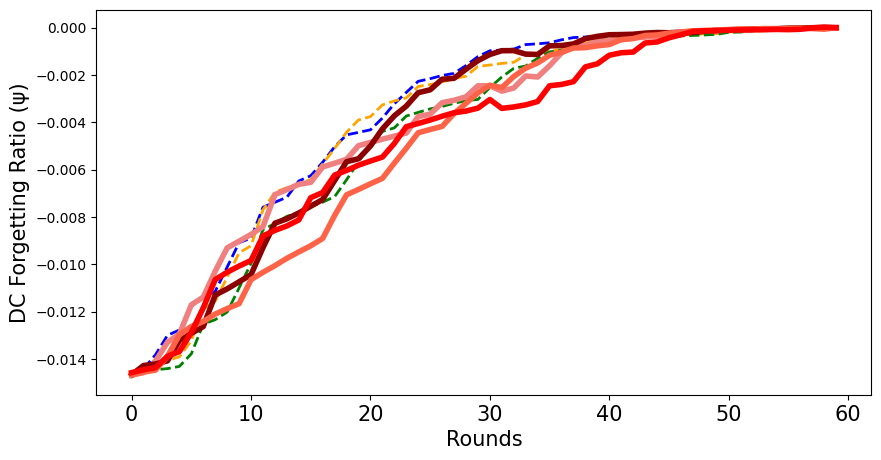

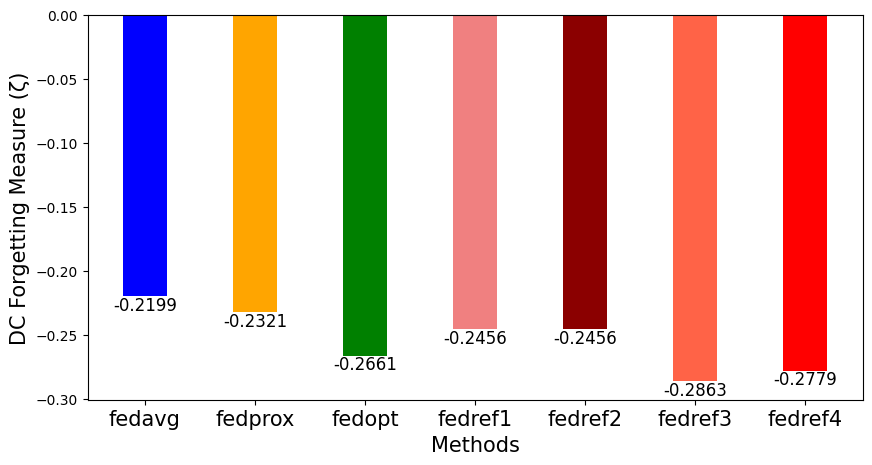

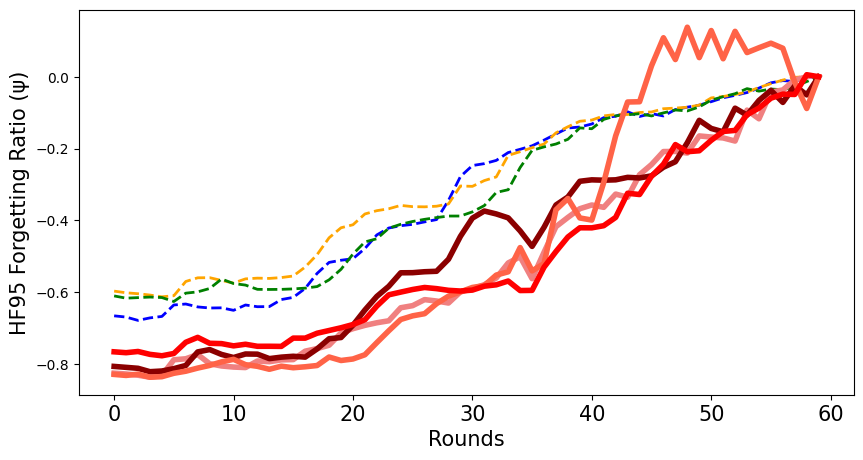

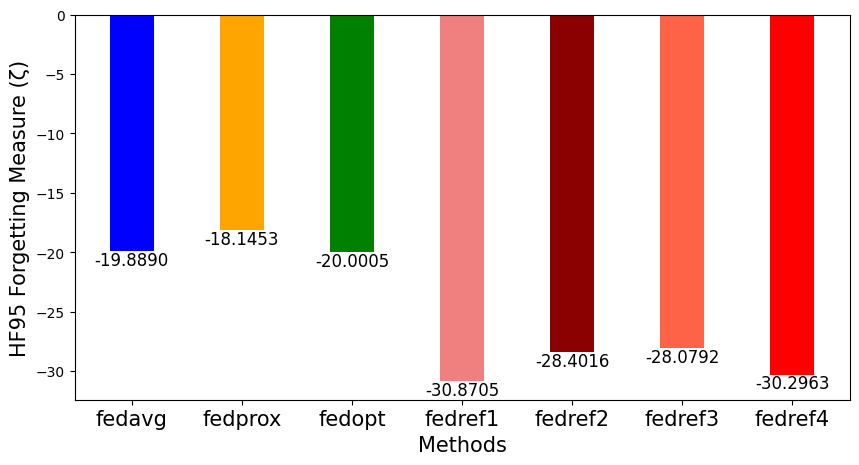

In [36]:
n=60
fedavg = pd.read_csv("Result/fedavg/fedavg_fets.csv")
fedprox = pd.read_csv("Result/fedprox/fedprox_fets.csv")
fedopt = pd.read_csv("Result/fedopt/fedopt_fets.csv")
fedref = [
    {**pd.read_csv("./Result/fedref/fedref_fets_lda11.0_p1.csv").to_dict("series"), **{"label":"fedref(λg:0.1, ρ:1)"}},
    {**pd.read_csv("./Result/fedref/fedref_fets_lda11.0_p3.csv").to_dict("series"), **{"label":"fedref(λg:0.1, ρ:3)"}},
    {**pd.read_csv("./Result/fedref/fedref_fets_lda11.0_p5.csv").to_dict("series"), **{"label":"fedref(λg:0.1, ρ:5)"}},
    {**pd.read_csv("./Result/fedref/fedref_fets_lda11.0_p7.csv").to_dict("series"), **{"label":"fedref(λg:0.1, ρ:7)"}}
    ]
whole_forgetting(fedavg, fedprox, fedopt,fedref, metrics=["mDice"], num=n)
whole_forgetting(fedavg, fedprox, fedopt,fedref, metrics=["mHF95"], num=n)

In [1]:
import pandas as pd
n=60
fedavg = pd.read_csv("Result/fedavg/fedavg_fets.csv")
fedprox = pd.read_csv("Result/fedprox/fedprox_fets.csv")
fedopt = pd.read_csv("Result/fedopt/fedopt_fets.csv")
fedref = [
    {**pd.read_csv("./Result/fedref/fedref_fets_lda11.0_p1.csv").to_dict("series"), **{"label":"fedref(λg:0.1, ρ:1)"}},
    {**pd.read_csv("./Result/fedref/fedref_fets_lda11.0_p3.csv").to_dict("series"), **{"label":"fedref(λg:0.1, ρ:3)"}},
    {**pd.read_csv("./Result/fedref/fedref_fets_lda11.0_p5.csv").to_dict("series"), **{"label":"fedref(λg:0.1, ρ:5)"}},
    {**pd.read_csv("./Result/fedref/fedref_fets_lda11.0_p7.csv").to_dict("series"), **{"label":"fedref(λg:0.1, ρ:7)"}}
    ]
print(max(fedavg["mDice"][:n]))
print(max(fedprox["mDice"][:n]))
print(max(fedopt["mDice"][:n]))
print("-----")
print(max(fedref[0]["mDice"][:n]))
print(max(fedref[1]["mDice"][:n]))
print(max(fedref[2]["mDice"][:n]))
print(max(fedref[3]["mDice"][:n]))

0.1415855293749364
0.1414299719144871
0.1414914851314511
-----
0.1414912070347067
0.1414890511294614
0.1414968547932913
0.1414116170049762


In [2]:
print(min(fedavg["mHF95"][:n]))
print(min(fedprox["mHF95"][:n]))
print(min(fedopt["mHF95"][:n]))
print("-----")
print(min(fedref[0]["mHF95"][:n]))
print(min(fedref[1]["mHF95"][:n]))
print(min(fedref[2]["mHF95"][:n]))
print(min(fedref[3]["mHF95"][:n]))

8.487517980536408
8.556057127340098
8.54300512386557
-----
8.318871657519747
8.346657520864715
8.186502066525547
8.381702515386767


In [49]:
import pandas as pd

df = pd.read_csv('Data/Fets2022/MICCAI_FeTS2021_TrainingData/partitioning_1.csv')
c1 = df[df['Partition_ID']==1]["Subject_ID"]
c2 = df[df['Partition_ID']==2]["Subject_ID"]
c3 = df[df['Partition_ID']==3]["Subject_ID"]
c4 = df[df['Partition_ID']==4]["Subject_ID"]
c5 = df[df['Partition_ID']==5]["Subject_ID"]
c6 = df[df['Partition_ID']==6]["Subject_ID"]
c7 = df[df['Partition_ID']==7]["Subject_ID"]
c8 = df[df['Partition_ID']==8]["Subject_ID"]
c9 = df[df['Partition_ID']==9]["Subject_ID"]
c10 = df[df['Partition_ID']==10]["Subject_ID"]
c11 = df[df['Partition_ID']==11]["Subject_ID"]
c12 = df[df['Partition_ID']==12]["Subject_ID"]
c13 = df[df['Partition_ID']==13]["Subject_ID"]
c14 = df[df['Partition_ID']==14]["Subject_ID"]
c15 = df[df['Partition_ID']==15]["Subject_ID"]
c16 = df[df['Partition_ID']==16]["Subject_ID"]
c17 = df[df['Partition_ID']==17]["Subject_ID"]

Text(0, 0.5, 'Volumes')

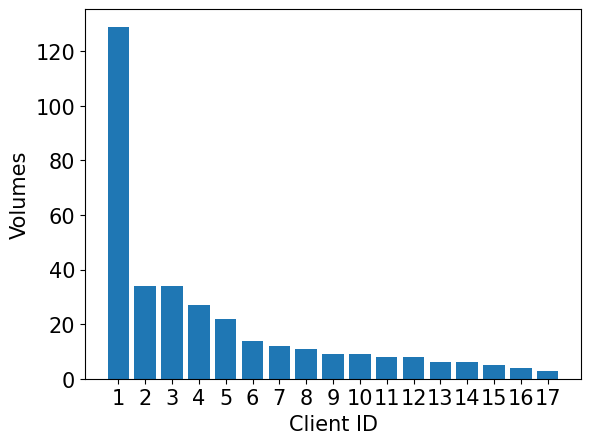

In [51]:
import matplotlib.pyplot as plt

plt.bar(range(1, 18, 1), sorted([len(globals()[f"c{i}"]) for i in range(1, 18)], reverse=True))
plt.xticks(range(1, 18, 1), fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel("Client ID", fontsize=15)
plt.ylabel("Volumes", fontsize=15)

Text(0.5, 1.0, 'partitioning 2')

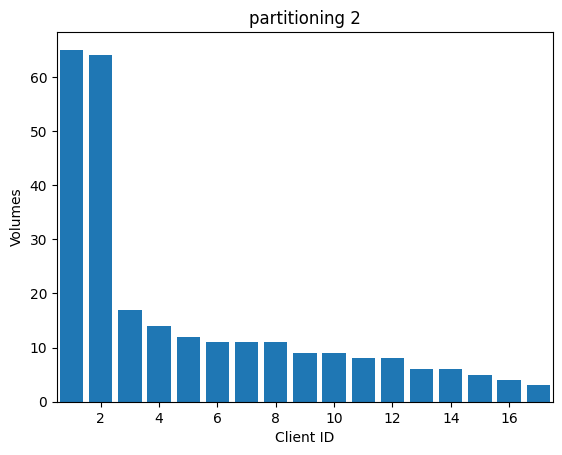

In [112]:
df = pd.read_csv('Data/Fets2022/MICCAI_FeTS2021_TrainingData/partitioning_2.csv')
c1 = df[df['Partition_ID']==1]["Subject_ID"]
c2 = df[df['Partition_ID']==2]["Subject_ID"]
c3 = df[df['Partition_ID']==3]["Subject_ID"]
c4 = df[df['Partition_ID']==4]["Subject_ID"]
c5 = df[df['Partition_ID']==5]["Subject_ID"]
c6 = df[df['Partition_ID']==6]["Subject_ID"]
c7 = df[df['Partition_ID']==7]["Subject_ID"]
c8 = df[df['Partition_ID']==8]["Subject_ID"]
c9 = df[df['Partition_ID']==9]["Subject_ID"]
c10 = df[df['Partition_ID']==10]["Subject_ID"]
c11 = df[df['Partition_ID']==11]["Subject_ID"]
c12 = df[df['Partition_ID']==12]["Subject_ID"]
c13 = df[df['Partition_ID']==13]["Subject_ID"]
c14 = df[df['Partition_ID']==14]["Subject_ID"]
c15 = df[df['Partition_ID']==15]["Subject_ID"]
c16 = df[df['Partition_ID']==16]["Subject_ID"]
c17 = df[df['Partition_ID']==17]["Subject_ID"]
import matplotlib.pyplot as plt

plt.bar(range(1, 18, 1), sorted([len(locals()[f"c{i}"]) for i in range(1, 18)], reverse=True))
plt.xlim(0.5, 17.5)
plt.xlabel("Client ID")
plt.ylabel("Volumes")
plt.title("partitioning 2")